## Проект номер 4

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

Данные:  
- order_id - id заказа
- delivery_time - время доставки в минутах
- district - район доставки
- experiment_group - экспериментальная группа

Загрузим df

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import scipy
from scipy import stats as ss
import math
import pingouin as pg
import statsmodels.api as sm
import statsmodels.stats

In [3]:
pizza_df=pd.read_csv('../Lesson4/experiment_lesson_4.csv')

In [4]:
pizza_df

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control
...,...,...,...,...
20191,14561,42.0,Suburb,test
20192,12015,32.0,Suburb,test
20193,20077,23.0,Purlieus,test
20194,14861,41.0,Central,test


In [57]:
pizza_df.isna().any()

order_id            False
delivery_time       False
district            False
experiment_group    False
dtype: bool

In [58]:
pizza_df.describe()

,order_id,delivery_time
count,20196.000000,20196.000000
mean,11103.503565,42.054169
std,5835.424404,10.382196
min,1000.000000,10.000000
25%,6048.750000,35.000000
50%,11109.500000,42.000000
75%,16158.250000,49.000000
max,21207.000000,83.000000


In [59]:
pizza_df.dtypes

order_id              int64
delivery_time       float64
district             object
experiment_group     object
dtype: object

## Задание 1
Сформулируйте нулевую и альтернативную гипотезы и постройте диаграммы распределения времени доставки по районам для тестовой и контрольной группы

Для начала сформулируем гипотезы для проверки:
- Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет
- Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть

Построим график распределения времени доставки в разрезе районов для тестовой и контрольной групп

district
Central     AxesSubplot(0.125,0.11;0.775x0.77)
Purlieus    AxesSubplot(0.125,0.11;0.775x0.77)
Suburb      AxesSubplot(0.125,0.11;0.775x0.77)
Name: delivery_time, dtype: object

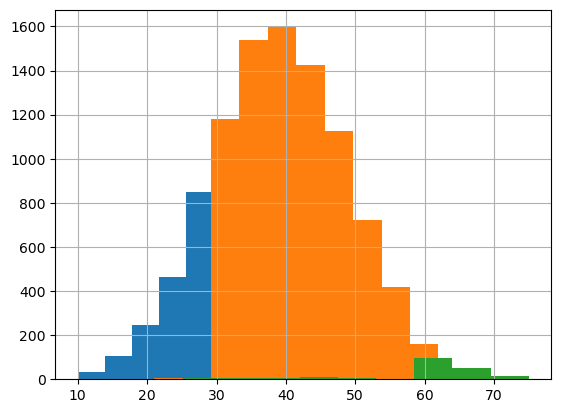

In [6]:
pizza_df \
    .query('experiment_group == "test"') \
    .groupby(['district']).delivery_time.hist() #тестовая группа

district
Central     AxesSubplot(0.125,0.11;0.775x0.77)
Purlieus    AxesSubplot(0.125,0.11;0.775x0.77)
Suburb      AxesSubplot(0.125,0.11;0.775x0.77)
Name: delivery_time, dtype: object

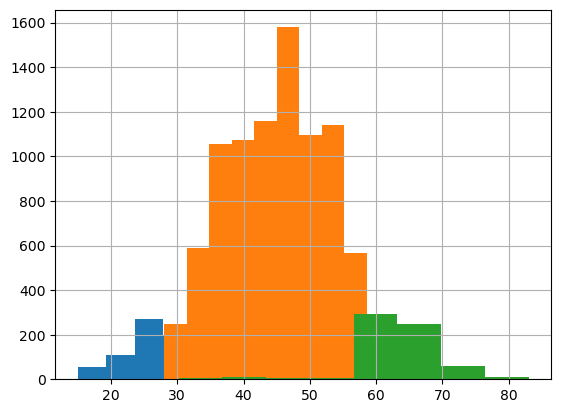

In [5]:
pizza_df \
    .query('experiment_group == "control"') \
    .groupby(['district']).delivery_time.hist() #контрольная группа

## Задание 2
Посчитайте количество наблюдений в тестовой и контрольной группе. На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [7]:
diff=pizza_df \
    .groupby(['experiment_group'], as_index=False) \
    .agg({'delivery_time':'count'})

In [9]:
diff

,experiment_group,delivery_time
0,control,10092
1,test,10104


Видим, что количество наблюдей в тестовой группе больше на 12

In [10]:
diff['delivery_time'][0]-diff['delivery_time'][1]

-12

## Задание 3
Проверим выполнение условий на нормальность и посчитаем std для test и control групп

Теперь давайте изучим наши распределения. Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.

Вообще для выборок таких колоссальных размеров мы не обязаны это делать - в отсутствие слишком уж выраженной асимметрии и выбросов в данных t-тест и так работать будет нормально, но посмотреть лишний раз всё равно можно

Обычно нормальность тестируют с помощью теста Шапиро-Уилка (scipy.stats.shapiro()), однако на больших выборках этот тест слишком рьяно находит отклонения от нормальности! Поэтому используйте функцию scipy.stats.normaltest() - она больше адаптирована к большим выборкам.

Рассчитав соответствующее t значение и зная число степеней свободы, мы можем рассчитать соответствующий р-уровень значимости, который скажет нам какая вероятность получить такое или еще более выраженное отличие между 2 средними, если на деле верна нулевая гипотеза.

Применяя Т-критерий Стьюдента нужно помнить о:

1. **Дисперсии** внутри наших групп должны быть примерно одинаковы (требование гомогенности дисперсий). Проверить можно с помощью критерия Левена и критерия Фишера
2. Особенно важный вопрос - это **требование к нормальности** данных обеих групп при применении t-теста. Во многих учебниках можно встретить довольно жесткое требование к нормальности данных по причине возможного завышения вероятности ошибки I рода.

На практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках и если в данных нет заметных выбросов. Однако при этом вы выходите на очень тонкий лёд - перед использованием t-теста на ненормальных данных дважды подумайте о своих жизненных решениях. Возможно, непараметрический тест или бутстрап окажутся лучше и адекватнее 

Проверим нормальность распределения двух групп с помощью шапиро

 Шапиро для больших выборок слишком рьяно находит отклонения от нормальности

In [14]:
scipy.stats.shapiro(pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time'])

ShapiroResult(statistic=0.998627781867981, pvalue=1.1720235448819949e-07)

поэтому используем другую фукнцию (тест Агостино-Пирсона) для проверки нормальности распределения тестовой группы


In [15]:
scipy.stats.normaltest(pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time'])

NormaltestResult(statistic=7.024157092641915, pvalue=0.02983483685333173)

теперь проверяем распределение контрольной группы

In [16]:
scipy.stats.normaltest(pizza_df[pizza_df['experiment_group'] == 'control']['delivery_time'])

NormaltestResult(statistic=0.25349755437872584, pvalue=0.8809549607809654)

(альтернатива) теперь проверяем распределение групп через normality пакета pinguin

In [17]:
pg.normality(data=pizza_df, dv='delivery_time', group='experiment_group', method='normaltest')

,W,pval,normal
experiment_group,,,
control,0.253498,0.880955,True
test,7.024157,0.029835,False


Видим, что на графике qq-plot данные тестовой группы более менее нормально распределены

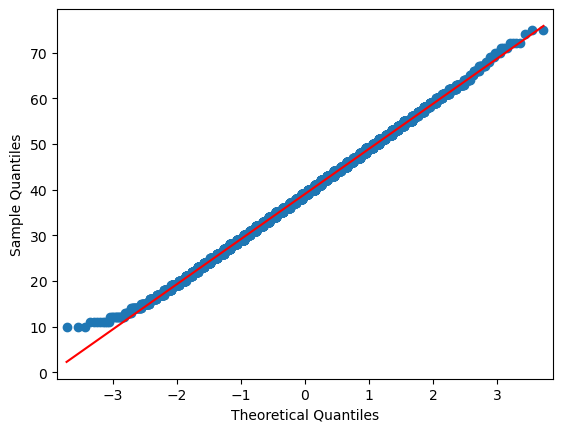

In [29]:
fig = sm.qqplot(pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time'], line='r')
plt.show()

Видим, что на графике qq-plot данные контрольной группы более менее нормально распределены

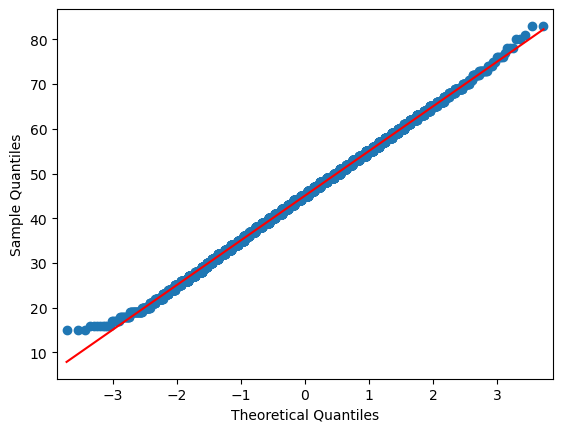

In [34]:
fig = sm.qqplot(pizza_df[pizza_df['experiment_group'] == 'control']['delivery_time'], line='r')
plt.show()

Проверим различие в дисперсиях. Видим, что дисперсии двух групп не отличаются

In [35]:
ss.levene(pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time'], \
         pizza_df[pizza_df['experiment_group'] == 'control']['delivery_time'])

LeveneResult(statistic=0.2702281101900882, pvalue=0.6031844931083392)

посмотрим на std двух групп

In [60]:
pizza_df.groupby('experiment_group').std()

,order_id,delivery_time
experiment_group,,
control,2913.453792,9.990017
test,2916.917894,9.883308


Итак, мы видим, что дисперсии групп не отличаются, но нормальное распределение только у контрольной группы.
Для того, чтобы посмотреть, какое значение покажет t-test для независимых переменных при разных дисперсиях, проведем такой тест с помощью statsmodels

С помощью Т-теста сравниваем средние. Получили p<0.05, отклоняем гипотезу о том, что средние двух групп равны
То есть новый алгоритм работает

In [62]:
ss.ttest_ind(pizza_df[pizza_df['experiment_group'] == 'control']['delivery_time'], \
                      pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time'], equal_var=True)
# equal_var = True дисперсии не отличаются

Ttest_indResult(statistic=43.03582663183714, pvalue=0.0)

t-test при параметре usevar='unequal' (дисперсии не равны) показывает такой же результат

In [63]:
statsmodels.stats.weightstats.ttest_ind(pizza_df[pizza_df['experiment_group'] == 'control']['delivery_time'], \
                               pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time'], \
                               alternative='two-sided', usevar='unequal')

(43.03555202424146, 0.0, 20191.127787584755)

Теперь проведем непараметрический тест Манна-Уитни и Yuen's t-test (trim = 0.2 - убираем 20% данных с конца и начала)

По yuen's t-test p-value показывает, что среднее время доставки в группах различается

In [66]:
ss.ttest_ind(pizza_df[pizza_df['experiment_group'] == 'control']['delivery_time'], \
                      pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time'], equal_var=True, \
                      trim = 0.2)

Ttest_indResult(statistic=42.16055367343425, pvalue=0.0)

Тест Манна-Уитни показывает, что среднее время доставки в группах различаются

In [73]:
ss.ttest_ind(pizza_df[pizza_df['experiment_group'] == 'control']['delivery_time'], \
                      pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time'], equal_var=True, \
                      permutations=1000)

Ttest_indResult(statistic=43.03582663183714, pvalue=0.0)

In [67]:
ss.mannwhitneyu(pizza_df[pizza_df['experiment_group'] == 'control']['delivery_time'], \
                         pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time'], \
                         alternative='two-sided')

MannwhitneyuResult(statistic=67984508.0, pvalue=0.0)

Узнаем, насколько время доставки сократилось. Считаем среднее значение времени доставки в тестовой группе

In [68]:
test_mean = (pizza_df[pizza_df['experiment_group'] == 'test']['delivery_time']).mean()

In [69]:
test_mean

39.04681314330958

Считаем среднее значение времени доставки в контрольной группе

In [70]:
control_mean = pizza_df[pizza_df['experiment_group'] == 'control']['delivery_time'].mean()

Смотрим, насколько изменилось время доставки после введения нового алгоритма.
Видим, что время доставки уменьшилось на 13 процентов

In [71]:
((test_mean-control_mean)/control_mean)*100

-13.354653121660812